
Plan: 

Eventually: gather historical data about a certain stock and use prediction models to predict what a price will be 
based on weeks/ months of data. The way we can probably do this is by training it off of a few different instances of 
historical data, and then using a different instance of historical data as the testing data. I'm considering using 
linear regression and random forest as general prediction models, and then looking more at what to do to get better 
predictors.

Currently: we are trying to figure out the best helpers from yfinance to use and how to organize the data so that we can 
actually use a training set and a testing set. I think we'll use 6 total sets, each that contain data for two months.
We'll then use the first 5 sets of data to train a model (starting with regression and random forest)

Then we'll run our model on our most recent two months of data and compare our results to the actual stock price. 

Additional: I think it would be cool to have a clustering model that clusters stocks based on their potential, essentially
giving a sell/hold/buy/strong buy, etc. rating via clustering. 


The data: 
We will start by using NVIDIA as our stock. This might change, as it may become aparent that NVIDIA is too volatile to predict
with machine learning models. This will be easy to change later. 

Attributes we want to use: EPS, P/E ratio, Market cap? (for growth potential?), industry, 


How to get EPS, PE ratio and market cap from yfinance:    (what is priceEpsCurrentYear? )
epsCurrentYear
forwardPE       (we're probably gonna change this to a current P/E of some sorts soon. not sure where it is in the data yet. )
marketCap


tickerData = yf.Ticker('NVDA').history(start="startDate" end="endDate")

In [11]:
'''
Setting up our dataframe and csv file
'''

import yfinance as yf
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb


NVIDIA = yf.Ticker("NVDA")

financials = NVIDIA.quarterly_financials
financial_columns = financials['2025-01-31']
print(financial_columns)
financials.to_csv("NVDA-quarterly-financials")

nvidiaInfo = NVIDIA.info
price = nvidiaInfo['ask']


NVDA_History = NVIDIA.history(start="2020-01-01", end="2026-01-01", interval="1d")
NVDA_History['Day'] = np.arange(len(NVDA_History))
NVDA_History['TP'] = (NVDA_History['Low'] + NVDA_History['High'] + NVDA_History['Close'])/3
NVDA_History['Change'] = NVDA_History['TP'].diff()


NVDA_History['Close'] = NVDA_History['Close'].round(2)
NVDA_History['Open'] = NVDA_History['Open'].round(2)
NVDA_History['High'] = NVDA_History['High'].round(2)
NVDA_History['Low'] = NVDA_History['Low'].round(2)
NVDA_History['Change'] = NVDA_History['Change'].round(2)
NVDA_History['TP'] = NVDA_History['TP'].round(2)

has_non_zeros = (NVDA_History['Dividends'] != 0).any()

NVDA_History.to_csv("NVDA-History.csv")

print("csv file setup done!\n\n\n")



NVDA_History.plot(kind='line', title='Open Price Over Time', x='Day', y='Open', label='Open')
NVDA_History.plot(kind='line', title='Volume Over Time', x='Day', y='Volume', label='Close')
plt.legend()
plt.show()





ModuleNotFoundError: No module named 'xgboost'

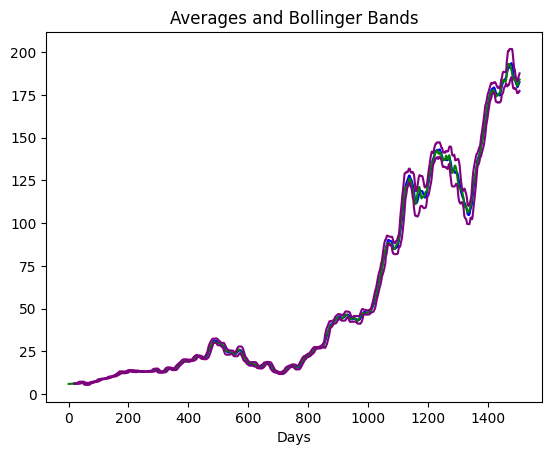

In [ ]:

'''
Calculating some metrics for price.

- Simple average
- Exponential Moving Average (EMA)
- Bollinger Bands, look more at specfics
- Momentum
- Volatility
- Stochastic oscillator?? idk what this really means so we'll do more research on it and see if we want it. 

Consider using typical price for these calculations, the average of low,high,close. 
'''

NVDA_History['TP'].to_numpy()

calculatedValues = pd.DataFrame()
calculatedValues['SMA_20'] = NVDA_History['TP'].rolling(window=20).mean()
calculatedValues['STD 20 Day'] = NVDA_History['TP'].rolling(window=20).std()
calculatedValues['EMA_20'] = NVDA_History['TP'].ewm(span=20, adjust=False).mean()


#Bollinger Bands:
calculatedValues["Bollinger Upper"] = calculatedValues['SMA_20'] + calculatedValues['STD 20 Day']
calculatedValues["Bollinger Lower"] = calculatedValues['SMA_20'] - calculatedValues['STD 20 Day']

plt.plot(NVDA_History['Day'], calculatedValues['SMA_20'], label="Moving Average", color='blue')
plt.plot(NVDA_History['Day'], calculatedValues['EMA_20'], label="Exponential Moving Average", color='green')
plt.plot(NVDA_History['Day'], calculatedValues['Bollinger Lower'], label="Bollinger Lower Bound", color="purple")
plt.plot(NVDA_History['Day'], calculatedValues['Bollinger Upper'], label="Bollinger Lower Bound", color="purple")

plt.title("Averages and Bollinger Bands")
plt.xlabel('Days')
plt.show()



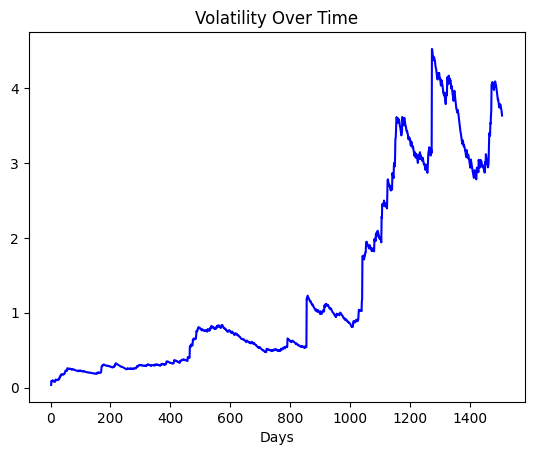

In [ ]:
calculatedValues['Volatility'] = NVDA_History['Change'].ewm(span=100, adjust=False).std()

plt.plot(NVDA_History['Day'], calculatedValues['Volatility'], label="Volatility", color='blue')
plt.xlabel('Days')
plt.title("Volatility Over Time")
plt.show()


In [ ]:
calculatedValues['Percent Change'] = (NVDA_History['Change']/NVDA_History['TP'])*100
calculatedValues.to_csv("calculatedValues.csv")

'''
Next steps: 

gotta make the next attributes percentages, determined from change category divided by the value 
times 100


then we do xgboost and the LSTM
'''


##each of these attributes needs to be converted into a percentage: 
#SMA_20, STD 20 Day, EMA_20, Bollinger Upper, Bollinger Lower, Volatility
attributesToUse = pd.DataFrame()
attributesToUse['Y Value Percent Change'] = calculatedValues['Percent Change'].shift(-10)
attributesToUse['Percent Change'] = calculatedValues['Percent Change']
attributesToUse['SMA Percent Change'] = (calculatedValues['SMA_20'].diff()/calculatedValues['SMA_20'])*100
attributesToUse['STD 20 Day Percent Change'] = (calculatedValues['STD 20 Day'].diff()/calculatedValues['STD 20 Day'])*100
attributesToUse['EMA 20 Percent Change'] = (calculatedValues['EMA_20'].diff()/calculatedValues['EMA_20'])*100
attributesToUse['Bollinger Upper Percent Change'] = (calculatedValues['Bollinger Upper'].diff()/calculatedValues['Bollinger Upper'])*100
attributesToUse['Bollinger Lower Percent Change'] = (calculatedValues['Bollinger Lower'].diff()/calculatedValues['Bollinger Lower'])*100
attributesToUse['Volatility Percent Change'] = (calculatedValues['Volatility'].diff()/calculatedValues['Volatility'])*100
attributesToUse.to_csv("finalAttributes.csv")



We finally have the csv with normalized attributes that we can start plugging into machine learning models. We will start with regression from scikit learn. After this we might try and use some classifiers, but will likely change pretty quickly to and LSTM or something similar. 

In [ ]:

'''
features = ['Percent Change', 'SMA Percent Change', 'STD 20 Day Percent Change', 'EMA 20 Percent Change', 'Bollinger Upper Percent Change', 'Bollinger Lower Percent Change', 'Volatility Percent Change']
X = attributesToUse[features]
Y = attributesToUse['Y Value Percent Change']

splitter = TimeSeriesSplit(n_splits=5)
------------------------------------
'''

#copied from gemini: 
'''
Not going to keep this code, but I want to run it, esspecially the second block, once I get home

-I need to use a format like this to start out with predicting based on each chronological fold.
-My main concern is making sure that the algorithms learn from all folds combined or one after another, and don't just forget 
after each iteration. 

'''
'''
for fold, (train_index, test_index) in enumerate(splitter.split(attributesToUse)):
    X_train, X_test = attributesToUse.iloc[train_index], attributesToUse.iloc[test_index]
    
    print(f"--- Fold {fold} ---")
    print(f"Train indices: {train_index} | Date Range: {X_train.index.min().date()} to {X_train.index.max().date()}")
    print(f"Test indices:  {test_index}  | Date Range: {X_test.index.min().date()} to {X_test.index.max().date()}")
'''
# 1. Setup Dummy Data (7 attributes + 1 target)
dates = pd.date_range(start='2024-01-01', periods=200, freq='D')
df = pd.DataFrame(np.random.randn(200, 7), columns=[f'attr_{i}' for i in range(1, 8)], index=dates)
# Create a binary target
df['target'] = (df['attr_1'] + df['attr_2'] > 0).astype(int)

# 2. Setup Splitter
tscv = TimeSeriesSplit(n_splits=4)
X = df.drop('target', axis=1)
y = df['target']

# Storage for plotting later
plot_data = []

# 3. THE LOOP
for fold, (train_index, test_index) in enumerate(tscv.split(df)):
    
    # --- Step A: Slice Data ---
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # --- Step B: Initialize & Train XGBoost INSIDE the loop ---
    # We create a new instance each time so it learns from scratch on the new (larger) dataset
    model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=3,
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False
    )
    
    model.fit(X_train, y_train)

    # --- Step C: Predict ---
    # predict_proba returns [prob_of_0, prob_of_1] -> we take index 1
    probs = model.predict_proba(X_test)[:, 1]
    
    # --- Step D: Store Results ---
    fold_result = pd.DataFrame({
        'date': X_test.index,
        'actual': y_test.values,
        'probability': probs
    })
    plot_data.append(fold_result)

# 4. Plotting
results = pd.concat(plot_data)

plt.figure(figsize=(10, 5))
plt.scatter(results['date'], results['actual'], color='black', alpha=0.3, label='Actual')
plt.plot(results['date'], results['probability'], color='green', linewidth=2, label='XGBoost Probability')
plt.axhline(0.5, color='red', linestyle='--')
plt.title("XGBoost Predictions over Time (Walk-Forward)")
plt.legend()
plt.show()




ModuleNotFoundError: No module named 'xgboost'